In [32]:
import numpy as np
import pandas as pd
from glob import glob


In [33]:
def load_config(config_path) -> dict:
    import yaml
    
    with open(config_path, "r") as config_file:
        return yaml.safe_load(config_file)


CONFIG = load_config("config.yaml")
for key in [
    "start_date",
    "end_date",
]:
    CONFIG[key] = pd.to_datetime(CONFIG[key]).tz_localize("UTC")

In [42]:
def plot_series(time, series, format="-", start=0, end=None):
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(15, 6))
    if type(series) is tuple:
        for i in range(len(series)):
            sns.lineplot(x=time[i][start:end], y=series[i][start:end])
    else:
        sns.lineplot(x=time[start:end], y=series[start:end])

    # plt.grid(True)
    plt.title('Spot Prices')
    plt.xlabel('Date')
    plt.ylabel('Value')


In [35]:
def generate_complete_time_df(id_instances: np.ndarray):
    complete_time_range = pd.date_range(
        start=CONFIG["start_date"],
        end=CONFIG["end_date"],
        freq=f"{CONFIG['timestep_hours']}h",
    )
    complete_time_df = pd.DataFrame({CONFIG["time_col"]: complete_time_range})
    complete_time_df = (
        complete_time_df.assign(key=1)
        .merge(pd.DataFrame({"id_instance": id_instances, "key": 1}), on="key")
        .drop("key", axis=1)
    )
    return complete_time_df


def read_prices_files(region: str):
    from glob import glob
    
    prices_files = glob(f"{CONFIG['data_folder']}/prices_{region}_*.csv")
    prices_df_list = []
    for file in prices_files:
        df = pd.read_csv(file)
        if df.empty and df.isna().all().all():
            continue

        prices_df_list.append(df)

    prices_df = pd.concat(prices_df_list, ignore_index=True)
    prices_df[CONFIG["time_col"]] = pd.to_datetime(
        prices_df[CONFIG["time_col"]], utc=True
    )
    prices_df = prices_df[
        (prices_df[CONFIG["time_col"]] >= CONFIG["start_date"])
        & (prices_df[CONFIG["time_col"]] <= CONFIG["end_date"])
    ]
    return prices_df


def merge_prices_with_time(prices_df: pd.DataFrame, complete_time_df: pd.DataFrame):
    prices_df[CONFIG["time_col"]] = prices_df[CONFIG["time_col"]].dt.floor(
        f"{CONFIG['timestep_hours']}h"
    )

    complete_time_df[CONFIG["time_col"]] = pd.to_datetime(
        complete_time_df[CONFIG["time_col"]], utc=True
    )

    prices_df = pd.merge(
        complete_time_df,
        prices_df,
        on=[CONFIG["time_col"], "id_instance"],
        how="left",
    )
    prices_df[CONFIG["target_col"]] = prices_df.groupby("id_instance")[
        CONFIG["target_col"]
    ].ffill()
    prices_df = prices_df.dropna(subset=[CONFIG["target_col"]])
    return prices_df


In [36]:
prices_df = read_prices_files('eu-central-1')

id_instances = prices_df["id_instance"].unique()
complete_time_df = generate_complete_time_df(id_instances)

prices_df = merge_prices_with_time(prices_df, complete_time_df)

In [37]:
prices_df.head()

,price_timestamp,id_instance,spot_price
2,2023-10-01 00:00:00+00:00,14500,0.2448
6,2023-10-01 00:00:00+00:00,25861,1.6511
10,2023-10-01 00:00:00+00:00,47182,0.3681
11,2023-10-01 00:00:00+00:00,11504,1.2817
18,2023-10-01 00:00:00+00:00,11923,12.5064


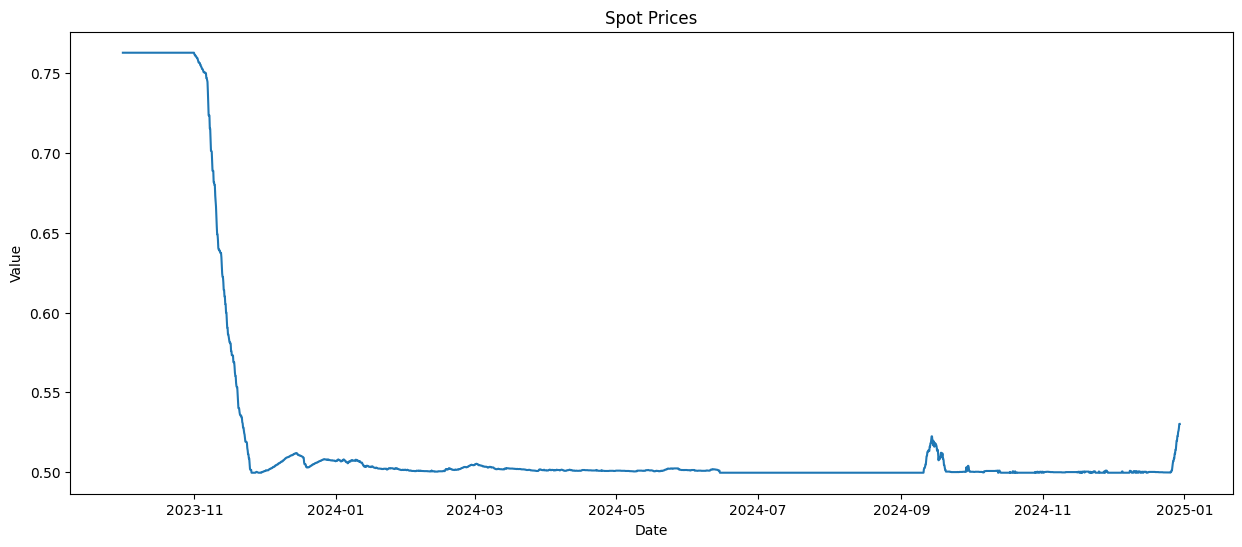

In [48]:
sampled_id_instances = np.random.choice(prices_df["id_instance"].unique(), size=1, replace=False)
random_prices_df = prices_df[prices_df["id_instance"].isin(sampled_id_instances)]

time = tuple(random_prices_df.groupby("id_instance")[CONFIG["time_col"]].apply(list))
series = tuple(random_prices_df.groupby("id_instance")[CONFIG["target_col"]].apply(list))

plot_series(time, series)

In [47]:
# Spliting into 94% and 6%
split_idx = int(len(random_prices_df) * 0.94)

# random_prices_df = random_prices_df.drop("id_instance")
# Split the dataframe into train and test sets
train_df = random_prices_df[:split_idx]
test_df = random_prices_df[split_idx:]
print(train_df.shape, test_df.shape)

(8756645, 3) (558935, 3)


In [ ]:
import timesfm

# For Torch
tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend="gpu",
        per_core_batch_size=32,
        horizon_len=128,
        num_layers=20,
        use_positional_embedding=False,
        context_len=2048,
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-2.0-500m-pytorch"
    ),
)

In [ ]:
forecast_df = tfm.forecast_on_df(
    train_df,
    freq="4H",
    value_name=CONFIG["target_col"],    
)

In [ ]:
forecast_df.head()

In [ ]:
test_df.head()

In [ ]:
import numpy as np
actuals = test_df['spot_price']
predicted_values = forecast_df['timesfm']
# Convert to numpy arrays
actual_values = np.array(actuals)
predicted_values = np.array(predicted_values)
# Calculate error metrics
MAE = np.mean(np.abs(actual_values - predicted_values))  # Mean Absolute Error
MSE = np.mean((actual_values - predicted_values)**2)     # Mean Squared Error
RMSE = np.sqrt(np.mean((actual_values - predicted_values)**2))  # Root Mean Squared Error
# Print the error metrics
print(f"Mean Absolute Error (MAE): {MAE}")
print(f"Mean Squared Error (MSE): {MSE}")
print(f"Root Mean Squared Error (RMSE): {RMSE}")

In [ ]:
# Let's Visualise the Data
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # Setting the warnings to be ignored
# Set the style for seaborn
sns.set(style="darkgrid")
# Plot size
plt.figure(figsize=(15, 6))
# Plot actual timeseries data
sns.lineplot(x="ds", y='timesfm', data=forecast_df, color='red', label='Forecast')
# Plot forecasted values
sns.lineplot(x="DATE", y='Value', data=random_prices_df, color='green', label='Actual Time Series')
# Set plot title and labels
plt.title('Electric Production: Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
# Show the legend
plt.legend()
# Display the plot
plt.show()